In [2]:
import re
import numpy as np
import pandas as pd
import os
from os import walk
import math

import cv2 as cv
import networkx as nx

import chart_studio.plotly as py
import plotly.offline as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from Shapes import shapes
from Lines import lines

In [3]:
file_path = '/Users/agetecza/CAM_Data/AT_CAM/Data/Clean' #path to data on local computer

In [4]:
#Function to get unique elements from a list
def list_unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
            
    return unique_list

In [5]:
def make_id_list(my_file_path):

    #pull all filenames in your data directory
    _, _, filenames = next(walk(my_file_path))

    #grab only the id from the filenames to feed to the function
    id_list = []
    for filename in filenames:
        filename_split = filename.rsplit('_', 1)
        id_list.append(filename_split[0])
    
    unique_id = list_unique(id_list) #drop duplicate ids, since they are the same for _blocks & _links
        
    
    
    return unique_id

In [6]:
#Get an id_list from your specific file path
my_id_list = make_id_list(file_path)

### Function to create a data frame of GLI (graph level indicies) for random sample of graphs of size n
#### n = number of nodes, p = probability of edge forming, sample_size = number of graphs to greate

In [7]:
def calc_CAM_GLI(id_list):
    
    dictionary_list = []
    
    for cam_id in id_list:
        
        try:
            df_blocks = pd.read_csv(f'{file_path}/{cam_id}_blocks.csv')
            df_links = pd.read_csv(f'{file_path}/{cam_id}_links.csv')
        

            # Get nodes
            nodes = df_blocks['id'].to_list()
            
            # Get edges
            edge_start = df_links['starting_block'].to_list()
            edge_end = df_links['ending_block'].to_list()
            edges = tuple(zip(edge_start, edge_end))
            
            # Create Graph
            G = nx.Graph()
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)
            
            # Calculate Density
            density = np.round(nx.density(G), 3)
            node_count = G.number_of_nodes()
            edge_count = G.size()
            
            # Calculate longest path
            try:
                components = nx.connected_components(G)
                largest_component = max(components, key=len)
                subgraph = G.subgraph(largest_component)
                diameter = nx.diameter(subgraph)
            except:
                diameter = 0
            # Calculate transitivity
            triadic_closure = np.round(nx.transitivity(G), 3)
            
            # Calculate max degree
            try:
                degree_centrality = nx.degree_centrality(G)
                max_centrality_ind = np.argmax(list(degree_centrality.values()))
                central_node = list(degree_centrality.keys())[max_centrality_ind]
                central_node_title = df_blocks[df_blocks['id'] == central_node]['title'].values[0]
                central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
            except:
                central_node = 0
                central_node_title = ''
                central_node_val = 0
                
            # Eigenvector Centrality
            try:
                eigenvector_centrality = nx.eigenvector_centrality(G)
                max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
                central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_eig = 0
                
            # Betweeness Centrality
            try:
                betweenness_centrality = nx.betweenness_centrality(G)
                max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
                central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_bet = 0

            # Make the dictionary
            density_dict = {
                'cam_id': cam_id,
                'node_count': node_count,
                'edge_count': edge_count,
                'density': density,
                'diameter': diameter,
                'triadic_closure': triadic_closure,
                'central_node': central_node,
                'central_node_title': central_node_title,
                'central_node_val': central_node_val,
                'central_node_val_eig': central_node_val_eig,
                'central_node_val_bet': central_node_val_bet
            }

            dictionary_list.append(density_dict)
            
        except:
            print(f'No file found for {cam_id}')
        
    cam_density_df = pd.DataFrame(dictionary_list)
            
    return cam_density_df

In [8]:
cam_GLI_df = calc_CAM_GLI(my_id_list)
display(cam_GLI_df)

No file found for 575ec4be3fc3ac000611df4c__771


,cam_id,node_count,edge_count,density,diameter,triadic_closure,central_node,central_node_title,central_node_val,central_node_val_eig,central_node_val_bet
0,5f32a496a026e809d7d55cbd_817,7,10,0.476,2,0.480,13562,Carbon Tax,1.000,0.595,0.667
1,5f67f8d55e7718150fd23bc7_802,8,11,0.393,2,0.400,13480,Carbon Tax,1.000,0.623,0.786
2,5e45dd10f354ca0c7f4225c7_903,10,9,0.200,5,0.000,14076,economic growth,0.444,0.566,0.722
3,5f4ae6a7ad7baa6aecef4234_990,14,13,0.143,7,0.000,14686,Unequal effect on classes and regions,0.231,0.471,0.667
4,5a4e8f4930adf7000106fd5e_928,12,12,0.182,6,0.000,14279,Financial Burden,0.364,0.470,0.636
...,...,...,...,...,...,...,...,...,...,...,...
153,5f57fef7e7b06a35296f215d_822,12,17,0.258,5,0.214,13629,Economy,0.455,0.467,0.544
154,5b0f33dd1e55760001b9a9ce_812,11,22,0.400,3,0.495,13542,Carbon Tax,0.800,0.470,0.369
155,5ca6c9f3a752220001ca1be3_838,9,6,0.167,3,0.333,13693,Carbon Tax,0.500,0.628,0.286
156,5f7dd740074da20008c51bf5_818,7,8,0.381,4,0.400,13566,Carbon Tax,0.667,0.552,0.567


In [9]:
def calc_sample_GLI(n, p, sample_size):
    density_dict_full = []
    
    for i in range(sample_size):
        G = nx.gnp_random_graph(n,p)
        density = np.round(nx.density(G), 3)
        edge_count = G.size()
        sample_id = f'sample_{i}'
        # Calculate longest path
        try:
            components = nx.connected_components(G)
            largest_component = max(components, key=len)
            subgraph = G.subgraph(largest_component)
            diameter = nx.diameter(subgraph)
        except:
            diameter = 0
        # Calculate transitivity
        triadic_closure = np.round(nx.transitivity(G), 3)
        # Calculate max degree
        try:
            degree_centrality = nx.degree_centrality(G)
            max_centrality_ind = np.argmax(list(degree_centrality.values()))
            central_node = list(degree_centrality.keys())[max_centrality_ind]
            central_node_title = i
            central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
        except:
            central_node = 0
            central_node_title = ''
            central_node_val = 0
        # Eigenvector Centrality
        try:
            eigenvector_centrality = nx.eigenvector_centrality(G)
            max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
            central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_eig = 0
        # Betweeness Centrality
        try:
            betweenness_centrality = nx.betweenness_centrality(G)
            max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
            central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_bet = 0
            
        density_dict = {
            'sample_id': sample_id,
            'edge_count': edge_count,
            'density': density,
            'diameter': diameter,
            'triadic_closure': triadic_closure,
            'central_node': central_node,
            'central_node_title': central_node_title,
            'central_node_val': central_node_val,
            'central_node_val_eig': central_node_val_eig,
            'central_node_val_bet': central_node_val_bet
        }
        
        density_dict_full.append(density_dict)
        
    density_df = pd.DataFrame(density_dict_full)
        
    return density_df

### For very small networks it looks unlikely that we can claim that centrality measures aren't due to chance

In [22]:
n = 10
p = .5
sample_size = 1000

cam_data_df = cam_GLI_df[cam_GLI_df['node_count']== n].copy().reset_index(drop=True)

sample_data_df = calc_sample_GLI(n, p, sample_size)

sample_data_df['Sample'] = 1
cam_data_df['Sample'] = 0

In [23]:
sample_n3_summary_df = pd.DataFrame(sample_data_df[['central_node_val','central_node_val_eig','central_node_val_bet']].describe()).transpose()
sample_n3_summary_df

,count,mean,std,min,25%,50%,75%,max
central_node_val,1000.0,0.742138,0.106005,0.444,0.66700,0.778,0.778,1.000
central_node_val_eig,1000.0,0.429697,0.030606,0.338,0.40875,0.427,0.448,0.548
central_node_val_bet,1000.0,0.201357,0.078556,0.037,0.14675,0.188,0.241,0.565


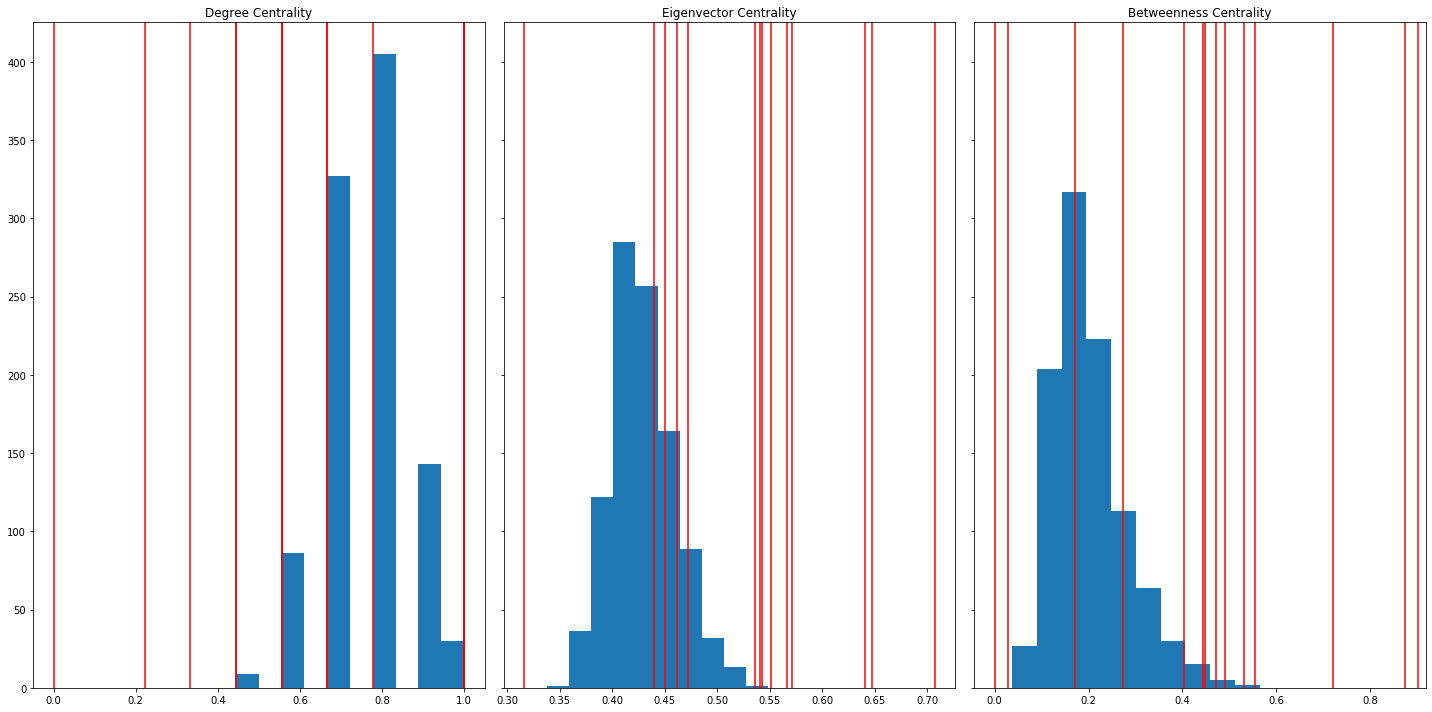

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20,10),sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(sample_data_df['central_node_val'])
axs[0].set_title('Degree Centrality')


axs[1].hist(sample_data_df['central_node_val_eig'])
axs[1].set_title('Eigenvector Centrality')

axs[2].hist(sample_data_df['central_node_val_bet'])
axs[2].set_title('Betweenness Centrality')
              
for i in range(len(cam_data_df)):
    axs[0].axvline(x=cam_data_df['central_node_val'][i], ymin=0, ymax=400, c='red')
    axs[1].axvline(x=cam_data_df['central_node_val_eig'][i], ymin=0, ymax=400, c='red')
    axs[2].axvline(x=cam_data_df['central_node_val_bet'][i], ymin=0, ymax=400, c='red')